# 3 варіант
Вагін Олександр Вікторович

Полiномiальна регресiя, алгоритм градiєнтного спуску з моментом, MSE з регуляризацiєю за нормою L1.

# Б

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import optuna
from sklearn.decomposition import PCA

sns.set(rc={'figure.figsize':(14, 8)})

# оскільки sklearn.datasets.load_boston уже застаріло і вже видалено у новійтній версії sklearn 
# то будемо завантажувати дані ось так:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]), columns=columns)
y = pd.Series(raw_df.values[1::2, 2], name='target')

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Epoch10Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % 10 == 0:
            print(f'Epoch: {epoch}')
            print(f'Loss = {logs["loss"]:.4f}, RMSE = {logs["root_mean_squared_error"]:.4f}, MSE = {logs["mean_squared_error"]:.4f}')
            print(f'Validation Loss = {logs["val_loss"]:.4f}, Validation RMSE = {logs["val_root_mean_squared_error"]:.4f}, Val MSE = {logs["val_mean_squared_error"]:.4f}')

In [3]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


## Подивимось на кореляції

<AxesSubplot: >

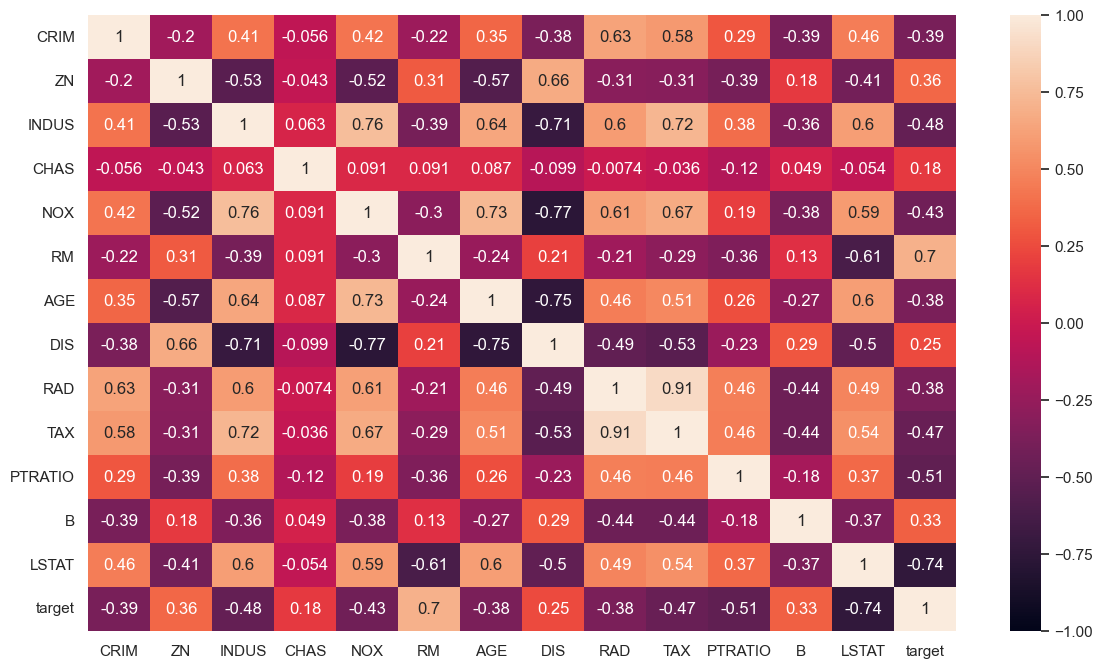

In [5]:
corr = pd.concat([X, y], axis=1).corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

Одразу видно, що потрібно видалити, або 'RAD', або 'TAX', також 'INDUS', або 'NOX', та 'NOX', або 'AGE', я вирішив видаляти: 'NOX', 'TAX'

<AxesSubplot: >

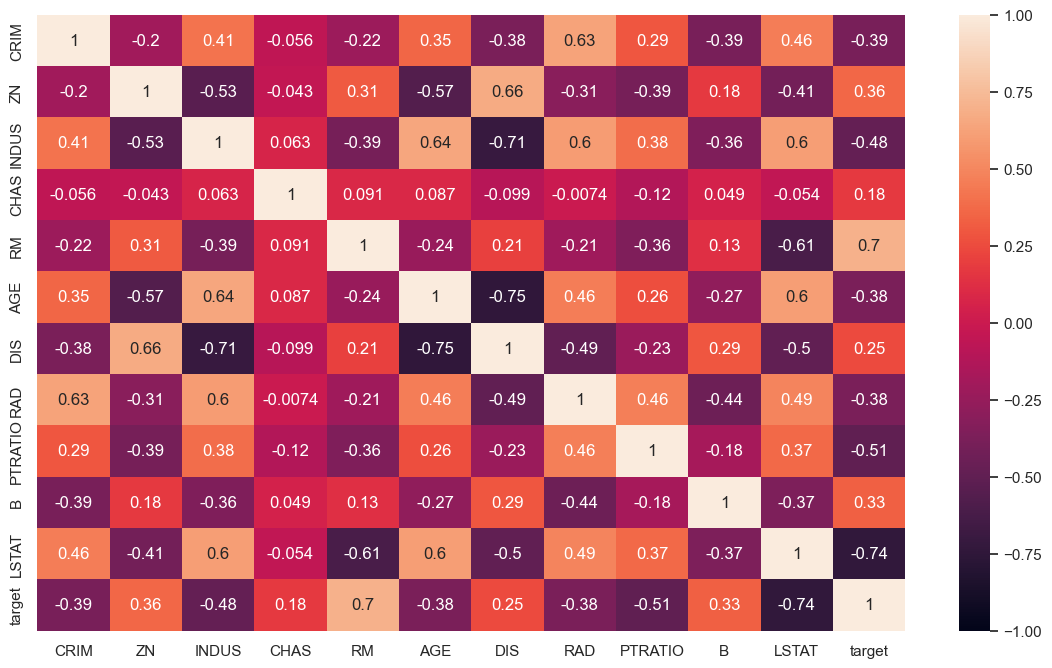

In [6]:
X = X.drop(['NOX', 'TAX'], axis=1)
corr = pd.concat([X, y], axis=1).corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

На мою думку усі інші корреляція не мають дуже високого значення і ми не отримаємо сильно виражену проблему мультиколлінеарності

## Графік даних:

Я насправді не придумав як відобразити наші графіки, тому я вирішив додати хоч якісь:

Гістограма:

[Text(0.5, 1.0, 'data'), Text(0, 0.5, 'y')]

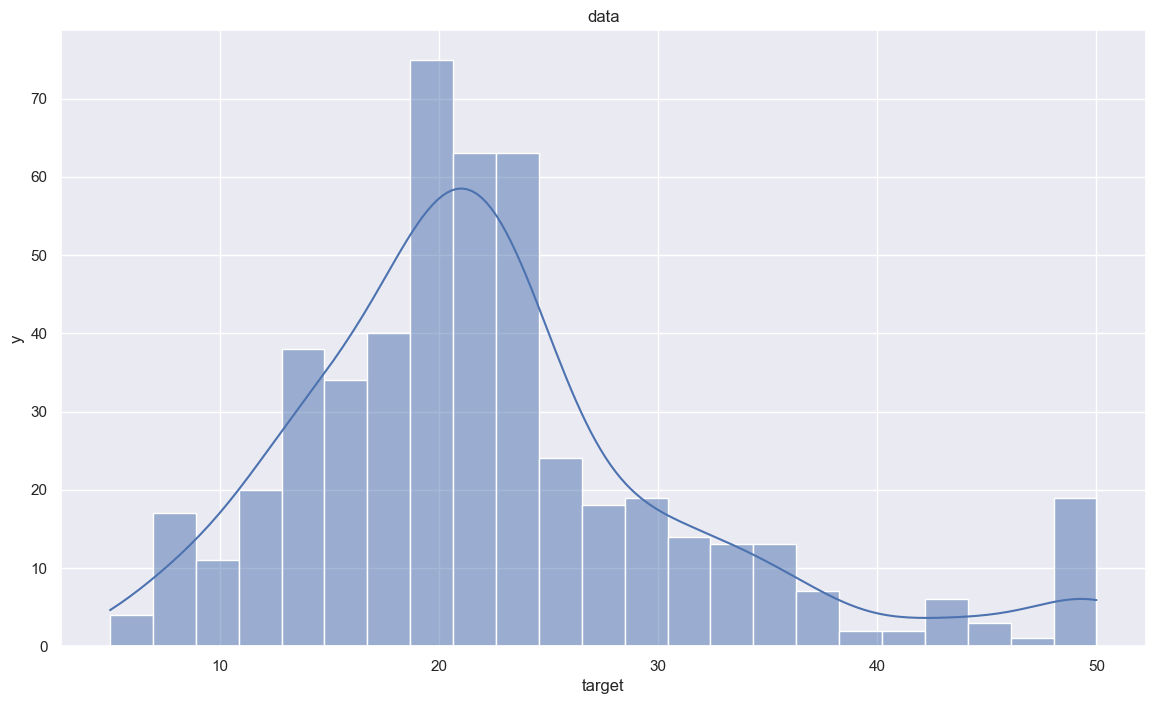

In [7]:
sns.histplot(y, kde=True).set(title='data', ylabel='y')

Візуалізація через PCA:

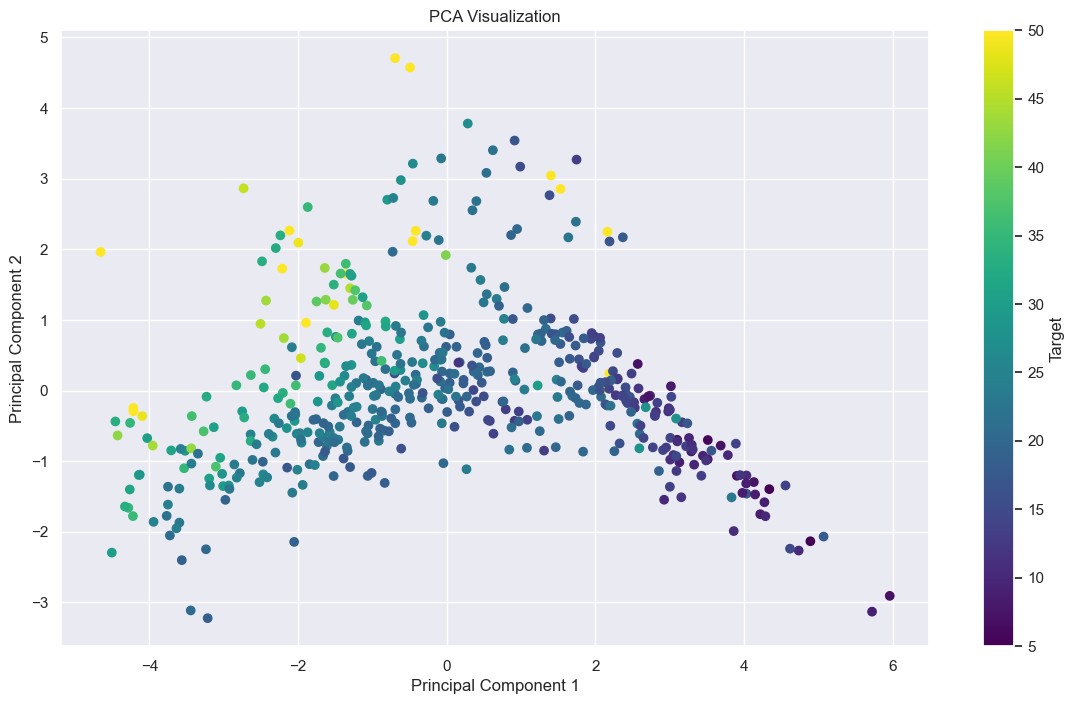

In [8]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a scatter plot
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=y, cmap='viridis')
plt.colorbar(label='Target')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()


Так звісно тут більше нічого очікувати коли ми візалізуємо через змінну за найбільшою корреляцією, але чому б і ні:

[Text(0.5, 1.0, 'data'), Text(0.5, 0, 'RM'), Text(0, 0.5, 'y')]

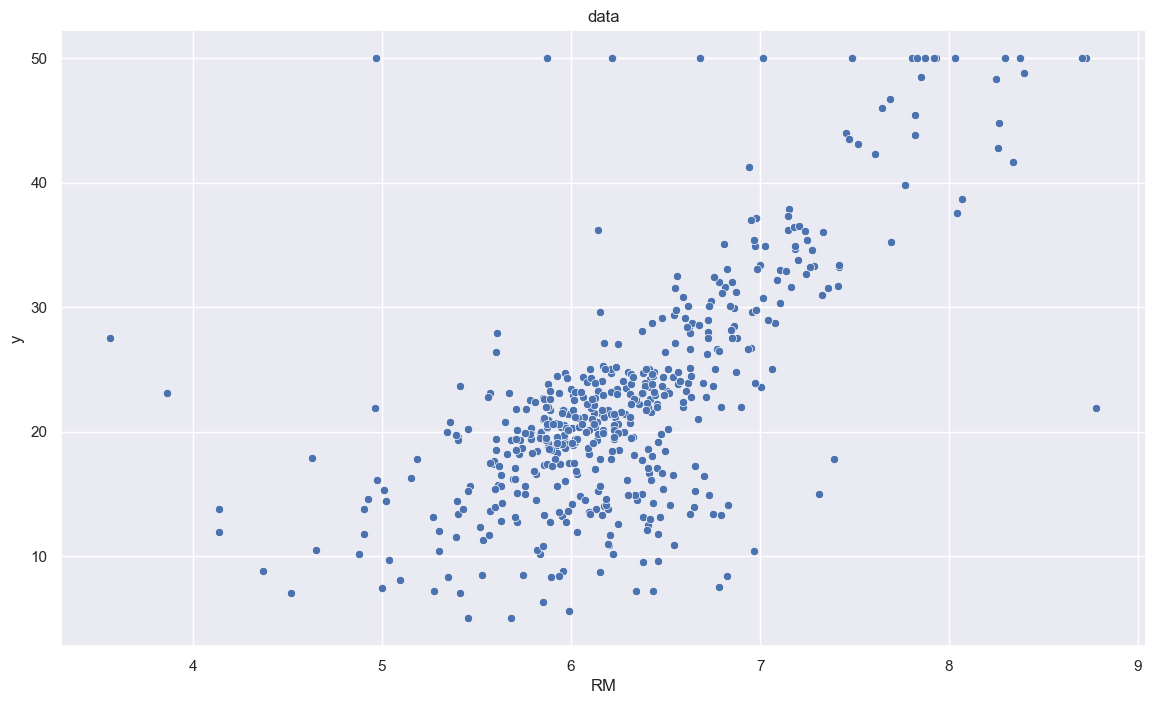

In [9]:
sns.scatterplot(x=X['RM'], y=y).set(title='data', xlabel='RM', ylabel='y')

## Підготуємо дані

Стандартизуємо дані, і створимо 3 датасети

Будемо створювати поліному 2 порядку, тому що у нас багато колонок, і з 3 поліномами буде вже забагато даних

In [10]:
X_train_val, X_test, y_train_val, y_test, _, principal_components_test  = train_test_split(X.values, y.values, principal_components, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

x_stdscaler = StandardScaler()

X_train = x_stdscaler.fit_transform(X_train)
X_train_val = x_stdscaler.transform(X_train_val)
X_test = x_stdscaler.transform(X_test)
X_val = x_stdscaler.transform(X_val)
X = x_stdscaler.transform(X.values)

poly = PolynomialFeatures(degree=2)

X_train = poly.fit_transform(X_train)
X_train_val = poly.transform(X_train_val)
X_test = poly.transform(X_test)
X_val = poly.transform(X_val)
X = poly.transform(X)

y_stdscaler = StandardScaler()

y_train = y_stdscaler.fit_transform(y_train.reshape(-1, 1))
y_train_val = y_stdscaler.transform(y_train_val.reshape(-1, 1))
y_test = y_stdscaler.transform(y_test.reshape(-1, 1))
y_val = y_stdscaler.transform(y_val.reshape(-1, 1))
y = y_stdscaler.transform(y.values.reshape(-1, 1))

In [11]:
pd.Series(y.flatten()).describe()

count    506.000000
mean      -0.023785
std        0.990920
min       -1.912815
25%       -0.617210
50%       -0.167385
75%        0.242037
max        2.935603
dtype: float64

In [12]:
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

X_train = tf.constant(X_train, dtype=tf.float32)
X_train_val = tf.constant(X_train_val, dtype=tf.float32)
X_test = tf.constant(X_test, dtype=tf.float32)
X_val = tf.constant(X_val, dtype=tf.float32)

y_train = tf.constant(y_train, dtype=tf.float32)
y_train_val = tf.constant(y_train_val, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.float32)
y_val = tf.constant(y_val, dtype=tf.float32)

## Підбір гіперпараметрів 

In [13]:
def objective(trial):
    
    # будемо підбирати С для регуляризації шару
    c_lambda_1 = trial.suggest_float("lambda_1", 1e-5, 1, log=True)
    # Також по завданню потрібно підібрати швидкість навчання
    lrng_rate = trial.suggest_float("lrng_rate", 1e-5, 1, log=True)
    
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(c_lambda_1))(inputs)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Використовувати будемо стохастичний градієнтний спуск з моментом, його параметр підбирати 
    # не будемо тому що від нього найбільше залежить швидкість збіжності алгоритму
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lrng_rate, momentum=0.3),
            loss='mean_squared_error',
            metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()])

    model.fit(X_train, y_train,
                    epochs=100,
                    verbose=0,
                    validation_data=(X_val, y_val))

    score = model.evaluate(X_val, y_val, verbose=0)
    return score[0]

In [14]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=15, timeout=600)

[I 2023-06-06 19:42:17,419] A new study created in memory with name: no-name-5c449dae-529c-40ee-8083-0778fb6111eb
[I 2023-06-06 19:42:23,220] Trial 0 finished with value: 0.2161315232515335 and parameters: {'lambda_1': 6.578890082612653e-05, 'lrng_rate': 0.002190663954702972}. Best is trial 0 with value: 0.2161315232515335.
[I 2023-06-06 19:42:28,909] Trial 1 finished with value: 1.5911359786987305 and parameters: {'lambda_1': 0.004423722889870081, 'lrng_rate': 4.734209672705043e-05}. Best is trial 0 with value: 0.2161315232515335.
[I 2023-06-06 19:42:34,743] Trial 2 finished with value: 0.3870813846588135 and parameters: {'lambda_1': 0.002340179136328442, 'lrng_rate': 0.010910452840373805}. Best is trial 0 with value: 0.2161315232515335.
[I 2023-06-06 19:42:40,673] Trial 3 finished with value: 2.4287095069885254 and parameters: {'lambda_1': 0.033944632804842584, 'lrng_rate': 0.0015059095617616137}. Best is trial 0 with value: 0.2161315232515335.
[I 2023-06-06 19:42:47,329] Trial 4 fin

In [15]:
best_params = []

for key, value in study.best_trial.params.items():
    best_params.append(value)
    print("{}: {}".format(key, value))

lambda_1: 3.003618489923863e-05
lrng_rate: 0.019032777937789676


## Навчання моделі
Тепер перенавчимо на додаткових зарезервованих даних

In [16]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(best_params[0]))(inputs)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=best_params[1], momentum=0.3),
        loss='mean_squared_error',
        metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_train_val, y_train_val,
                    epochs=100,
                    callbacks=[ Epoch10Callback(),
                               tf.keras.callbacks.ModelCheckpoint(filepath="model_2b",
                                                                  save_best_only=True, verbose=0,
                                                                  save_weights_only=True)],
                    verbose=0,
                    validation_data=(X_test, y_test))

y_pred_test = model.predict(X_test)
y_pred_full = model.predict(X)

Epoch: 0
Loss = 2.1274, RMSE = 1.4570, MSE = 2.1230
Validation Loss = 12.2147, Validation RMSE = 3.4943, Val MSE = 12.2103
Epoch: 10
Loss = 0.1602, RMSE = 0.3946, MSE = 0.1557
Validation Loss = 0.1783, Validation RMSE = 0.4169, Val MSE = 0.1738
Epoch: 20
Loss = 0.1133, RMSE = 0.3299, MSE = 0.1088
Validation Loss = 0.1552, Validation RMSE = 0.3882, Val MSE = 0.1507
Epoch: 30
Loss = 0.0950, RMSE = 0.3008, MSE = 0.0905
Validation Loss = 0.1557, Validation RMSE = 0.3889, Val MSE = 0.1512
Epoch: 40
Loss = 0.0839, RMSE = 0.2817, MSE = 0.0794
Validation Loss = 0.1514, Validation RMSE = 0.3833, Val MSE = 0.1469
Epoch: 50
Loss = 0.0803, RMSE = 0.2752, MSE = 0.0757
Validation Loss = 0.1502, Validation RMSE = 0.3817, Val MSE = 0.1457
Epoch: 60
Loss = 0.0752, RMSE = 0.2658, MSE = 0.0707
Validation Loss = 0.1482, Validation RMSE = 0.3791, Val MSE = 0.1437
Epoch: 70
Loss = 0.0709, RMSE = 0.2577, MSE = 0.0664
Validation Loss = 0.1603, Validation RMSE = 0.3948, Val MSE = 0.1558
Epoch: 80
Loss = 0.0677

## Візалізація результатів

На мою думку найкраще буде візуалізувати результати через PCA, та гістограму 

### PCA:

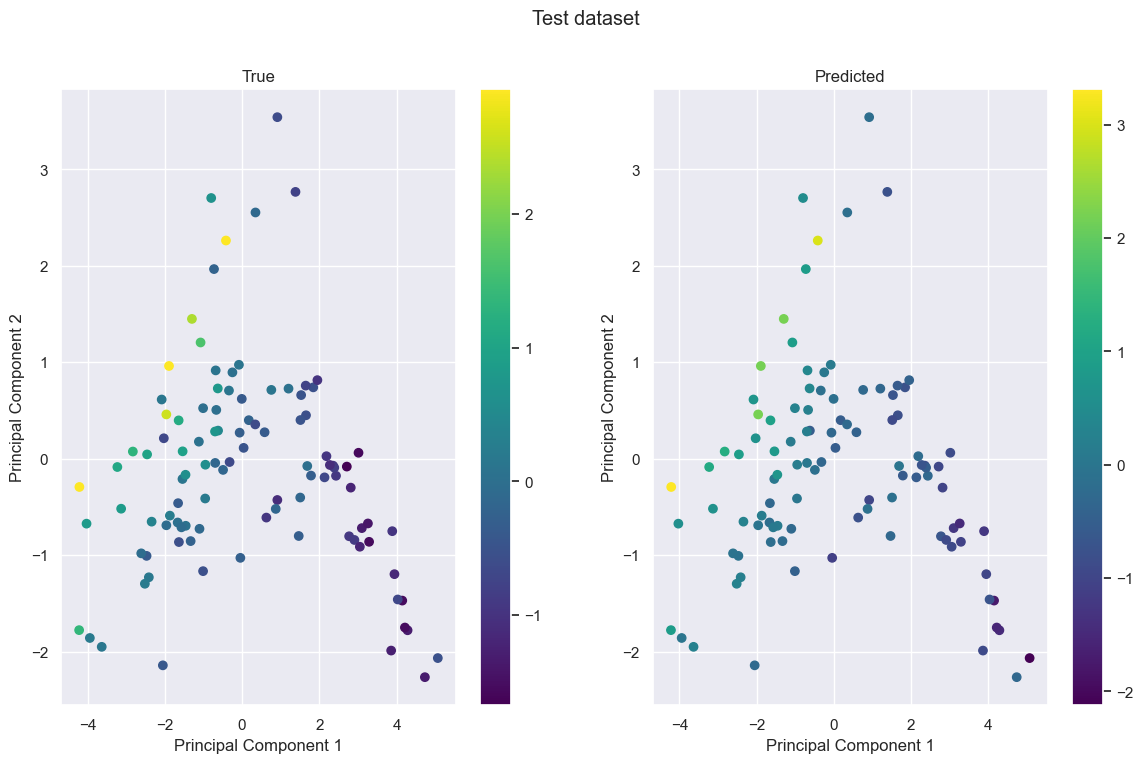

In [23]:
fig, axs = plt.subplots(1, 2)

scatter1 = axs[0].scatter(principal_components_test[:, 0], principal_components_test[:, 1], c=y_test.numpy(), cmap='viridis')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')
axs[0].set_title('True')

cbar1 = plt.colorbar(scatter1, ax=axs[0])

scatter2 = axs[1].scatter(principal_components_test[:, 0], principal_components_test[:, 1], c=y_pred_test, cmap='viridis')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].set_title('Predicted')

cbar2 = plt.colorbar(scatter2, ax=axs[1])

fig.suptitle(f'Test dataset, MSE: {history.history["val_mse"][-1]}')
plt.show()

З цієї візуалізації ми бачимо, що наша модель дуже близка до реальних даних

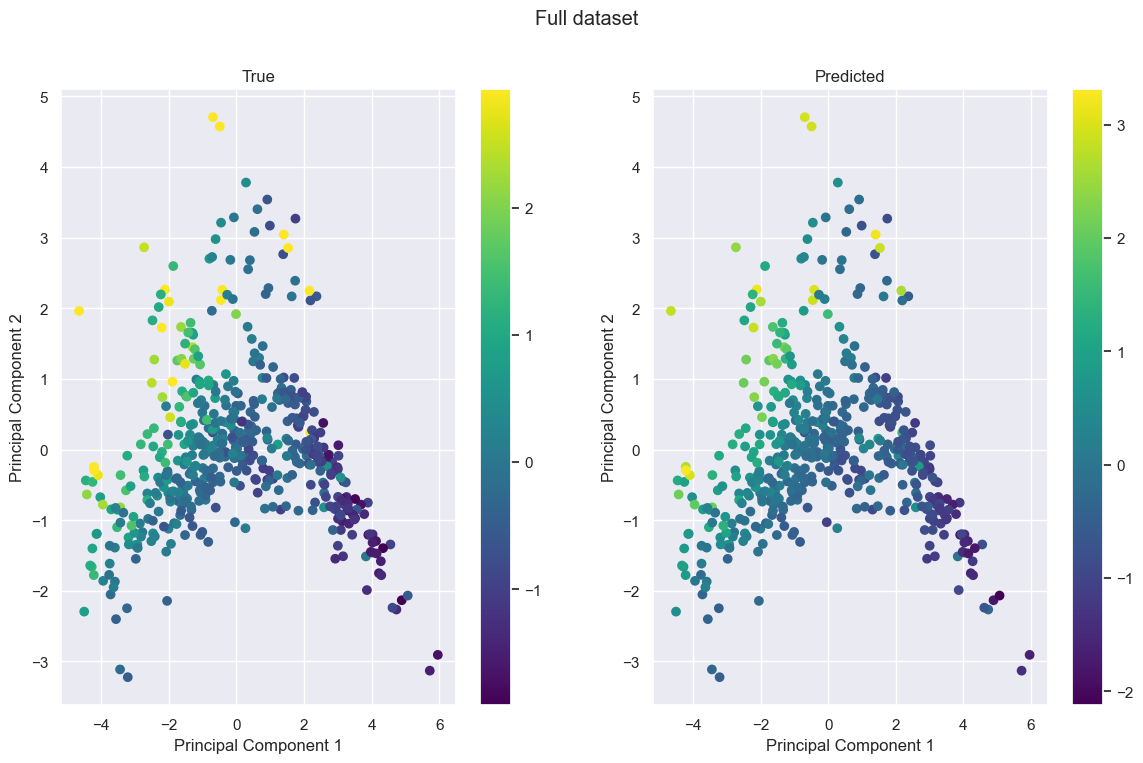

In [24]:
fig, axs = plt.subplots(1, 2)

scatter1 = axs[0].scatter(principal_components[:, 0], principal_components[:, 1], c=y.numpy(), cmap='viridis')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')
axs[0].set_title('True')

cbar1 = plt.colorbar(scatter1, ax=axs[0])

scatter2 = axs[1].scatter(principal_components[:, 0], principal_components[:, 1], c=y_pred_full, cmap='viridis')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].set_title('Predicted')

cbar2 = plt.colorbar(scatter2, ax=axs[1])

fig.suptitle(f'Full dataset, MSE: {history.history["val_mse"][-1]}')
plt.show()

На усьому датасеті ми бачимо таке же саме

### Гістограмми

На жаль вони чомусь не працюють так як потрібно, seaborn'у загалом не має різниці до того який колір я ставлю, а через plt kde дуже складно виводити, тому залишу, так, усе рівно видно, що ми отримали дуже близкі результати

Через іншу змінну виводити не будемо тому що цей графік виявився дуже не інформативним

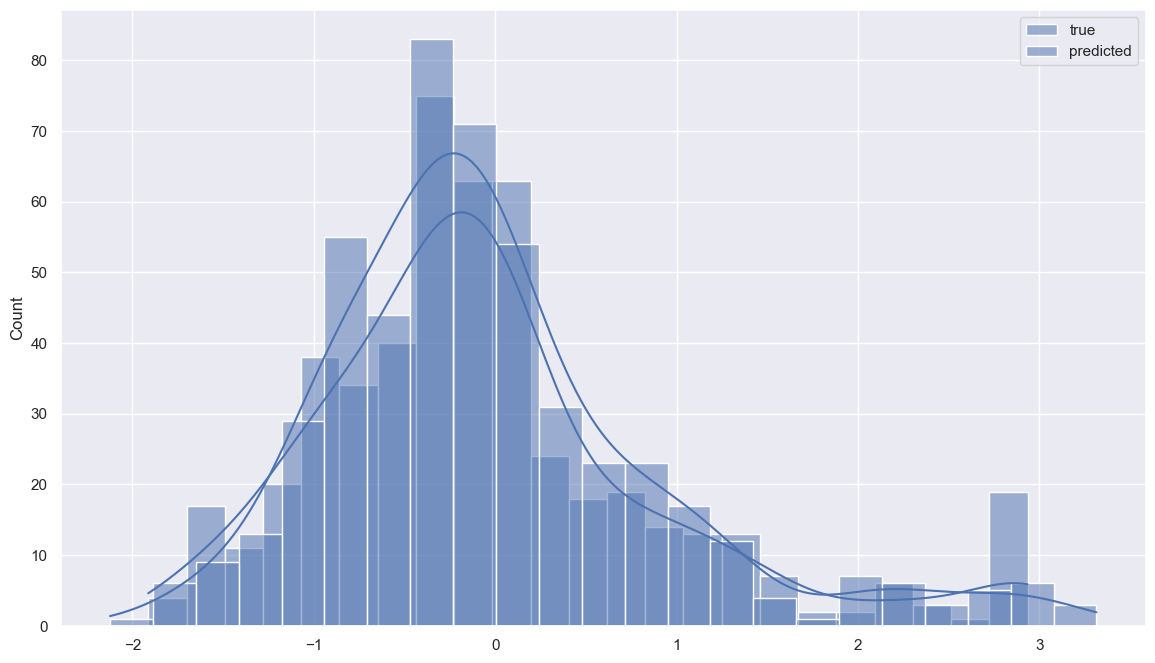

In [25]:
fig, ax = plt.subplots()

sns.histplot(y.numpy(), color='orange', label='true', ax=ax, alpha=0.5, kde=True)
sns.histplot(y_pred_full, label='predicted', ax=ax, alpha=0.5, kde=True, color='asfdівавфіаa')
plt.legend(loc='upper right')
plt.show()

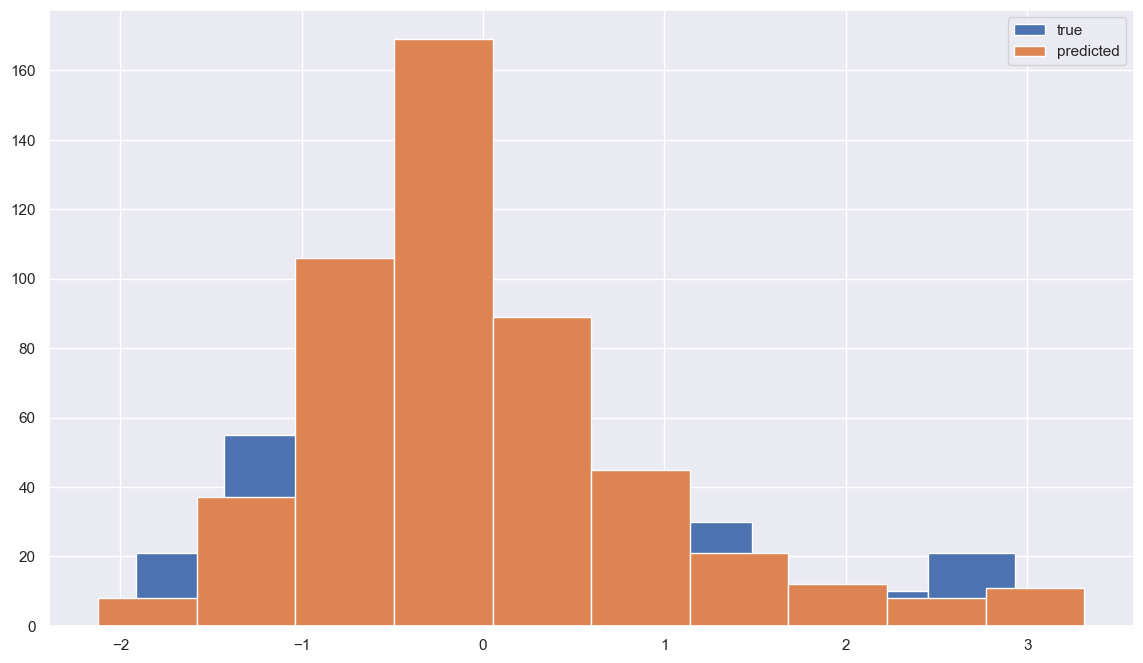

In [26]:
plt.hist(y.numpy(), label='true')
plt.hist(y_pred_full, label='predicted')
plt.legend(loc='upper right')
plt.show()

### Криві зміни функції втрат, та середньоквадратичної похибки 

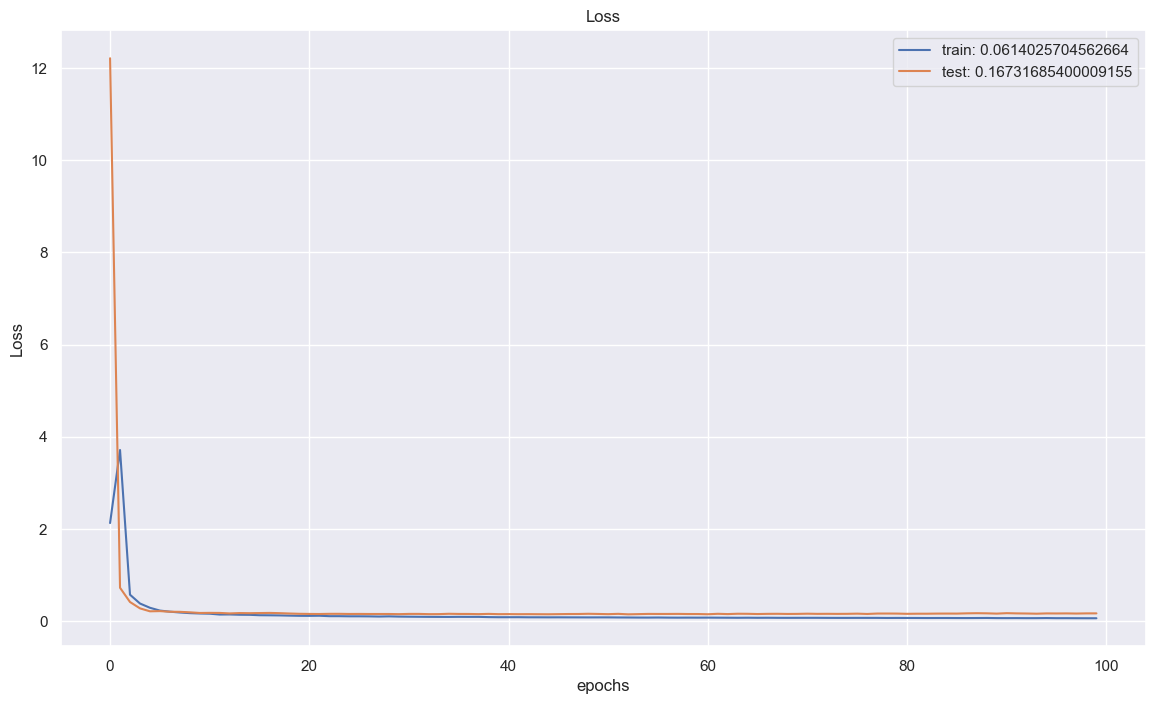

In [27]:
plt.plot(history.history['loss'], label=f"train: {history.history['loss'][-1]}")
plt.plot(history.history['val_loss'], label=f"test: {history.history['val_loss'][-1]}")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Loss')
plt.legend()
plt.show()

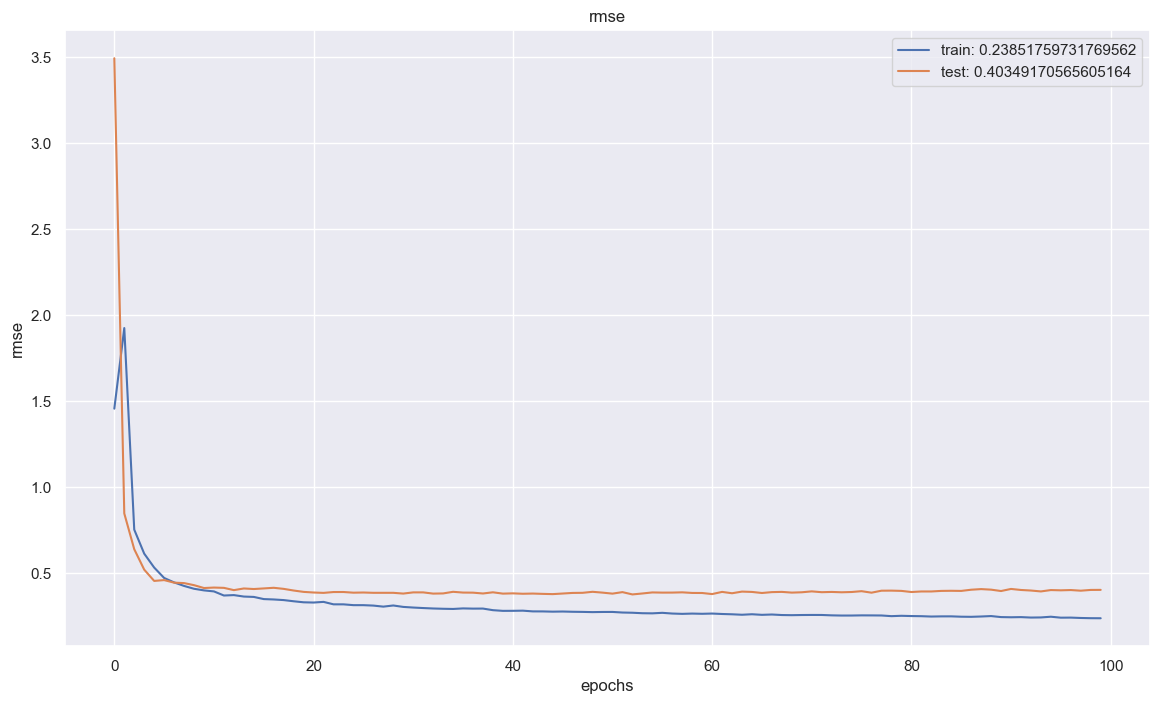

In [28]:
plt.plot(history.history['root_mean_squared_error'], label=f"train: {history.history['root_mean_squared_error'][-1]}")
plt.plot(history.history['val_root_mean_squared_error'], label=f"test: {history.history['val_root_mean_squared_error'][-1]}")
plt.xlabel("epochs")
plt.ylabel("rmse")
plt.title('rmse')
plt.legend()
plt.show()

Модель навчалася стабільно, без стрибків, у результаті ми отримали низькі значення похибок, що дуже добре

## Висновки

Як ми бачимо наша модель гарно показала себе на даних, ми отримали низькі значення MSE та RMSE, візуалізація для цього датасету була не простим завданням, але на мою думку через PCA ми отримали досить не погану візуалізацію